# Tutorial 1

Tags:
* Pytorch
* Two-class classification (bees and ants)
* Data-augmentation
* Finetuning (retrain the whole network using pretrained weights)
* Convolutional layers as feature extractors

This notebook was inspired in [this](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) tutorial (**Transfer Learning Tutorial** by pytorch.org).

Environment: [env_tutorial_1.yaml](http://localhost:8888/edit/tutorials/tutorial_1/env_tutorial_1.yml)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from utils import fetch_dataset

### Define dataset

In [5]:
####################################################################
# Downloading dataset                                              #
####################################################################
#current_dir = os.path.dirname(os.path.realpath(__file__))
URL = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
DIR_DATASETS = '../datasets'
dir_dataset = os.path.join(DIR_DATASETS, URL[URL.rfind('/')+1:]).replace('.zip','')
# If dataset not downloaded yet, download and decompress it
if not os.path.exists(dir_dataset):
    res, dir_dataset = fetch_dataset(URL, DIR_DATASETS, decompress=True)
    if not res:
        print('Error downloading dataset')

In [6]:
####################################################################
# Data augmentation and normalization for training                 #
####################################################################
# Define mean and std used to generate the pretrained imagenet
mean_imagenet =[0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Crop the given PIL Image to random size and aspect ratio.
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
        #  for each channel of the input torch.Tensor 
        # i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]
        transforms.Normalize(mean_imagenet, std_imagenet)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_imagenet, std_imagenet)
    ]),
}


In [7]:
####################################################################
# Define dataset                                                   #
####################################################################
# Create Dataset objects from out directory with their corresponding transformation
image_datasets = {x: datasets.ImageFolder(os.path.join(dir_dataset, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# Create DataLoader objects loading the dataset
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=4, #how many samples per batch to load (default: 1)
                                             shuffle=True, #to have the data reshuffled at every epoch 
                                             num_workers=4) #how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process
              for x in ['train', 'val']}
# Get sizes of the train and val datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# Get the name of the classes used for training
class_names = image_datasets['train'].classes
# Set device used in the machine
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device.type}")

Device used: cuda


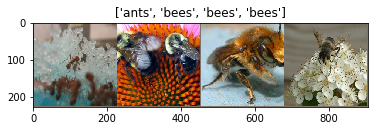

In [8]:
#Visualizing a random batch
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean_imagenet)
    std = np.array(std_imagenet)
    # denormalize data
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of the training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
# Show images
imshow(out, title=[class_names[x] for x in classes])

### Finetuning a model

We will perform a finetuning in a Resnet18 model. For that, instead of random initializaion, we will load a pretrained resnet18 with imagenet dataset and reset final fully connected layer.

All the convolutional weights and FC layer weights will be updated during the training.

In [9]:
####################################################################
# Train a network                                                  #
####################################################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = None

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Tell the optmizer scheduler that a step was taken so it can update the parameters to be optimized
                scheduler.step()
                model.train()  # Set model to training mode
            else: # validation phase
                model.eval()   # Set model to evaluate mode
            # Initiate loss and correct values
            running_loss = 0.0
            running_corrects = 0

            # Iterate over the data (one loop by batch)
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Observations:
                # inputs.shape = [batch_size, channels, height, width]
                # labels.shape = [batch_size]
                # label = 0 or 1 (ant or bee)                                
                # Reset the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Forward the inputs into the model in the model
                    outputs = model(inputs)
                    # Get the prediction
                    _, preds = torch.max(outputs, 1)
                    # Calculate the loss between labels and outputs
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # Update weights by backwarding the loss
                        loss.backward()
                        # Tell the optmizer scheduler that a step was taken so it can update the parameters to be optimized
                        optimizer.step() 
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
               # Update best epoch accuracy and model
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    # Finished training
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} (Epoch: %d)'.format(best_acc)%best_epoch)
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
##################################################
# Load the model (Resnet)
##################################################
resnet18 = models.resnet18(pretrained=True)
# Get the last full connected (FC) and reset it
num_ftrs = resnet18.fc.in_features # Get number of inputs of the FC
# As we have two classes (ants and bees), set the FC to have 2 outputs
resnet18.fc = nn.Linear(in_features=num_ftrs, out_features=2)
resnet18 = resnet18.to(device)
# As we have a classification problem, let's define the loss as the Cross Entropy
criterion = nn.CrossEntropyLoss()
# Define a Stochastic Gradient Descent (SGD) with momentum as our optimizer
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [11]:
##################################################
# Train and evaluate the model
##################################################
model_ft = train_model(resnet18, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7907 Acc: 0.5000
val Loss: 0.6548 Acc: 0.5948

Epoch 1/24
----------
train Loss: 0.7603 Acc: 0.2500
val Loss: 0.6137 Acc: 0.6471

Epoch 2/24
----------
train Loss: 0.5513 Acc: 0.6250
val Loss: 0.5698 Acc: 0.7059

Epoch 3/24
----------
train Loss: 0.5410 Acc: 1.0000
val Loss: 0.4977 Acc: 0.7843

Epoch 4/24
----------
train Loss: 0.2197 Acc: 1.0000
val Loss: 0.4804 Acc: 0.7386

Epoch 5/24
----------
train Loss: 0.2435 Acc: 1.0000
val Loss: 0.4666 Acc: 0.7516

Epoch 6/24
----------
train Loss: 0.3227 Acc: 0.8750
val Loss: 0.4443 Acc: 0.7647

Epoch 7/24
----------
train Loss: 0.2583 Acc: 1.0000
val Loss: 0.4441 Acc: 0.7778

Epoch 8/24
----------
train Loss: 0.2318 Acc: 1.0000
val Loss: 0.4425 Acc: 0.7778

Epoch 9/24
----------
train Loss: 0.1496 Acc: 1.0000
val Loss: 0.4407 Acc: 0.7843

Epoch 10/24
----------
train Loss: 0.0918 Acc: 1.0000
val Loss: 0.4315 Acc: 0.7974

Epoch 11/24
----------
train Loss: 0.1034 Acc: 1.0000
val Loss: 0.4312 Acc: 0.7974

Ep

### Visualize the results

In [12]:
########################################################
# Define evaluation of few images by a trained model   #
########################################################
def visualize_model(model, num_images=6):
    # Get the model initial status (training or evaluating)
    was_training = model.training # Boolean
    # Set model to evaluation mode
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    # We don’t need the gradients when just using the model
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Pass the inputs by the model
            outputs = model(inputs)
            # Get the prediction
            _, preds = torch.max(outputs, 1)
            # Loop through each image in the input
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # Get class of the prediction
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    # Set the model to its initial status
                    model.train(mode=was_training)
                    return
        # Set the model to its initial status
        model.train(mode=was_training)

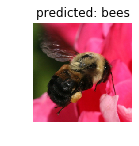

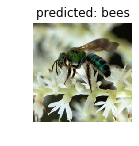

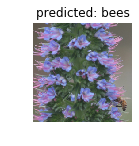

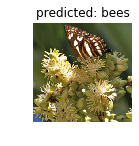

In [13]:
########################################################
# Visualize the classification of a few images         #
########################################################
visualize_model(resnet18, num_images = 4)

### Freeze all Convolutional Layer weights

Suppose we want to train only the final FC layer to use the Convolutional Layers as feature extractors.

For that, we need to freeze all network except the final FC layer. So we need to set ```requires_grad = False``` to avoid the gradients to be computed in the ```backward()```.

In [14]:
########################################################
# Freeze the Convolutional layers                      #
########################################################
# Load a resnet18 with pretrained weights
model_conv = torchvision.models.resnet18(pretrained=True)
# Loop through each parameter and freeze it
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_features = model_conv.fc.in_features
# Reset the FC layer- requires_grad by default is True
model_conv.fc = nn.Linear(num_features, 2)
# Set the model to the device
model_conv = model_conv.to(device)
# As it is a classification problem, let's define the Cross Entropy as the loss
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
########################################################
# Train the last FC layer                              #
########################################################
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8926 Acc: 0.2500
val Loss: 0.8702 Acc: 0.3660

Epoch 1/24
----------
train Loss: 0.7696 Acc: 0.5000
val Loss: 0.8184 Acc: 0.4575

Epoch 2/24
----------
train Loss: 0.7264 Acc: 0.5000
val Loss: 0.7248 Acc: 0.5098

Epoch 3/24
----------
train Loss: 0.6658 Acc: 0.7500
val Loss: 0.6449 Acc: 0.5817

Epoch 4/24
----------
train Loss: 0.6127 Acc: 0.5000
val Loss: 0.5805 Acc: 0.6993

Epoch 5/24
----------
train Loss: 0.4854 Acc: 0.7500
val Loss: 0.5323 Acc: 0.7451

Epoch 6/24
----------
train Loss: 0.3475 Acc: 1.0000
val Loss: 0.4939 Acc: 0.7843

Epoch 7/24
----------
train Loss: 0.3078 Acc: 1.0000
val Loss: 0.4938 Acc: 0.7712

Epoch 8/24
----------
train Loss: 0.3081 Acc: 1.0000
val Loss: 0.4937 Acc: 0.7516

Epoch 9/24
----------
train Loss: 0.6045 Acc: 0.6250
val Loss: 0.4893 Acc: 0.7647

Epoch 10/24
----------
train Loss: 0.3208 Acc: 1.0000
val Loss: 0.4902 Acc: 0.7451

Epoch 11/24
----------
train Loss: 0.3659 Acc: 0.8750
val Loss: 0.4859 Acc: 0.7582

Ep

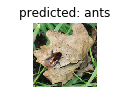

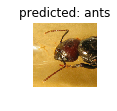

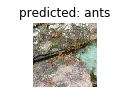

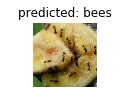

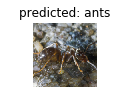

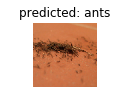

In [16]:
########################################################
# Visualize the classification of a few images         #
########################################################
visualize_model(model_conv)

plt.ioff()
plt.show()
